In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')

In [19]:
data = np.array(data)  # Convert the data to a NumPy array
m, n = data.shape  # Get the number of samples (m) and features (n)
np.random.shuffle(data)  # Shuffle the dataset to ensure randomness

# Split data into development and training sets
data_dev = data[0:1000].T  # Take the first 1000 samples for development set and transpose
Y_dev = data_dev[0]  # Labels for the development set
X_dev = data_dev[1:n]  # Features for the development set
X_dev = X_dev / 255.  # Normalize pixel values to range [0, 1]

data_train = data[1000:m].T  # Use the remaining samples for training set and transpose
Y_train = data_train[0]  # Labels for the training set
X_train = data_train[1:n]  # Features for the training set
X_train = X_train / 255.  # Normalize pixel values to range [0, 1]
_, m_train = X_train.shape  # Get the number of features and samples in the training set

In [20]:
def init_params():
    """
    Initialize parameters for a 2-layer neural network.
    Returns:
        W1: Weight matrix for the first layer of shape (10, 784)
        b1: Bias vector for the first layer of shape (10, 1)
        W2: Weight matrix for the second layer of shape (10, 10)
        b2: Bias vector for the second layer of shape (10, 1)
    """
    W1 = np.random.rand(10, 784) - 0.5  # Random weights for the first layer
    b1 = np.random.rand(10, 1) - 0.5  # Random biases for the first layer
    W2 = np.random.rand(10, 10) - 0.5  # Random weights for the second layer
    b2 = np.random.rand(10, 1) - 0.5  # Random biases for the second layer
    return W1, b1, W2, b2

def ReLU(Z):
    """
    Apply the ReLU activation function element-wise.
    Args:
        Z: Input matrix of shape (number of neurons, number of examples)
    Returns:
        Activated matrix where all negative values are set to zero
    """
    return np.maximum(Z, 0)

def softmax(Z):
    """
    Apply the softmax activation function to compute probabilities.
    Args:
        Z: Input matrix of shape (number of classes, number of examples)
    Returns:
        Probability matrix where each column sums to 1
    """
    exp_Z = np.exp(Z - np.max(Z, axis=0, keepdims=True))  # Subtract max for numerical stability
    A = exp_Z / np.sum(exp_Z, axis=0, keepdims=True)  # Compute softmax
    return A

def forward_prop(W1, b1, W2, b2, X):
    """
    Perform forward propagation through the network.
    Args:
        W1: Weight matrix for the first layer
        b1: Bias vector for the first layer
        W2: Weight matrix for the second layer
        b2: Bias vector for the second layer
        X: Input features matrix
    Returns:
        Z1: Linear combination output of the first layer
        A1: Activation of the first layer after ReLU
        Z2: Linear combination output of the second layer
        A2: Activation of the second layer after softmax (final output)
    """
    Z1 = W1.dot(X) + b1  # Compute linear combination for the first layer
    A1 = ReLU(Z1)  # Apply ReLU activation function
    Z2 = W2.dot(A1) + b2  # Compute linear combination for the second layer
    A2 = softmax(Z2)  # Apply softmax activation function
    return Z1, A1, Z2, A2

def ReLU_deriv(Z):
    """
    Compute the derivative of the ReLU activation function.
    Args:
        Z: Input matrix
    Returns:
        Matrix indicating where Z was positive (1) or zero (0)
    """
    return Z > 0

def one_hot(Y):
    """
    Convert labels to one-hot encoded vectors.
    Args:
        Y: Vector of labels
    Returns:
        one_hot_Y: One-hot encoded matrix
    """
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))  # Create a matrix of zeros
    one_hot_Y[np.arange(Y.size), Y] = 1  # Set appropriate indices to 1
    one_hot_Y = one_hot_Y.T  # Transpose to match required shape
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    """
    Perform backward propagation to compute gradients.
    Args:
        Z1: Linear combination output of the first layer
        A1: Activation of the first layer
        Z2: Linear combination output of the second layer
        A2: Activation of the second layer (final output)
        W1: Weight matrix for the first layer
        W2: Weight matrix for the second layer
        X: Input features matrix
        Y: True labels
    Returns:
        dW1: Gradient of the weights for the first layer
        db1: Gradient of the biases for the first layer
        dW2: Gradient of the weights for the second layer
        db2: Gradient of the biases for the second layer
    """
    one_hot_Y = one_hot(Y)  # Convert true labels to one-hot encoded vectors
    dZ2 = A2 - one_hot_Y  # Compute error term for the output layer
    dW2 = 1 / m * dZ2.dot(A1.T)  # Compute gradient of weights for the second layer
    db2 = 1 / m * np.sum(dZ2, axis=1, keepdims=True)  # Compute gradient of biases for the second layer
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)  # Compute error term for the hidden layer
    dW1 = 1 / m * dZ1.dot(X.T)  # Compute gradient of weights for the first layer
    db1 = 1 / m * np.sum(dZ1, axis=1, keepdims=True)  # Compute gradient of biases for the first layer
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    """
    Update parameters using gradient descent.
    Args:
        W1: Weight matrix for the first layer
        b1: Bias vector for the first layer
        W2: Weight matrix for the second layer
        b2: Bias vector for the second layer
        dW1: Gradient of the weights for the first layer
        db1: Gradient of the biases for the first layer
        dW2: Gradient of the weights for the second layer
        db2: Gradient of the biases for the second layer
        alpha: Learning rate
    Returns:
        Updated weights and biases
    """
    W1 = W1 - alpha * dW1  # Update weights for the first layer
    b1 = b1 - alpha * db1  # Update biases for the first layer
    W2 = W2 - alpha * dW2  # Update weights for the second layer
    b2 = b2 - alpha * db2  # Update biases for the second layer
    return W1, b1, W2, b2
    

In [21]:
def get_predictions(A2):
    """
    Get predicted class labels from the output activations.
    Args:
        A2: Final activation probabilities
    Returns:
        Array of predicted class labels
    """
    return np.argmax(A2, axis=0)  # Get the index of the maximum value in each column

def get_accuracy(predictions, Y):
    """
    Compute the accuracy of predictions compared to true labels.
    Args:
        predictions: Array of predicted class labels
        Y: Array of true labels
    Returns:
        Accuracy as a proportion of correct predictions
    """
    print(predictions, Y)  # Print predictions and true labels for debugging
    return np.sum(predictions == Y) / Y.size  # Compute accuracy

def gradient_descent(X, Y, alpha, iterations):
    """
    Perform gradient descent to optimize the neural network parameters.
    
    Args:
        X: Input features matrix of shape (num_features, num_examples)
        Y: True labels vector of shape (num_examples,)
        alpha: Learning rate (float)
        iterations: Number of iterations for gradient descent (int)
    
    Returns:
        W1: Optimized weight matrix for the first layer
        b1: Optimized bias vector for the first layer
        W2: Optimized weight matrix for the second layer
        b2: Optimized bias vector for the second layer
    """
    # Initialize the parameters
    W1, b1, W2, b2 = init_params()
    
    # Iterate through the number of specified iterations
    for i in range(iterations):
        # Perform forward propagation to get activations and linear combinations
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        
        # Perform backward propagation to get gradients
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        
        # Update the parameters using the gradients and learning rate
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        
        # Print the iteration number and accuracy every 50 iterations
        if i % 50 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))
    
    # Return the optimized parameters
    return W1, b1, W2, b2


In [23]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 0.10, 500)

Iteration:  0
[0 0 0 ... 8 0 0] [8 7 3 ... 5 6 3]
0.07221951219512195
Iteration:  10
[3 4 3 ... 9 3 3] [8 7 3 ... 5 6 3]
0.15909756097560976
Iteration:  20
[3 4 3 ... 1 3 3] [8 7 3 ... 5 6 3]
0.22931707317073172
Iteration:  30
[3 4 3 ... 9 3 3] [8 7 3 ... 5 6 3]
0.30209756097560975
Iteration:  40
[3 4 3 ... 9 3 3] [8 7 3 ... 5 6 3]
0.3631463414634146
Iteration:  50
[3 6 3 ... 9 3 3] [8 7 3 ... 5 6 3]
0.4228780487804878
Iteration:  60
[1 6 3 ... 9 3 3] [8 7 3 ... 5 6 3]
0.47573170731707315
Iteration:  70
[1 6 3 ... 9 6 1] [8 7 3 ... 5 6 3]
0.5225609756097561
Iteration:  80
[1 4 3 ... 9 6 1] [8 7 3 ... 5 6 3]
0.5598048780487805
Iteration:  90
[8 4 3 ... 9 6 1] [8 7 3 ... 5 6 3]
0.5930487804878048
Iteration:  100
[8 4 3 ... 9 6 1] [8 7 3 ... 5 6 3]
0.6185121951219512
Iteration:  110
[8 4 3 ... 9 6 1] [8 7 3 ... 5 6 3]
0.6407560975609756
Iteration:  120
[8 4 3 ... 8 6 1] [8 7 3 ... 5 6 3]
0.6581707317073171
Iteration:  130
[8 4 3 ... 8 6 1] [8 7 3 ... 5 6 3]
0.6743414634146342
Iteration:  

~85% accuracy on training set.

In [24]:
ef make_predictions(X, W1, b1, W2, b2):
    """
    Make predictions using the trained neural network model.
    
    Args:
        X: Input features matrix of shape (num_features, num_examples)
        W1: Weight matrix for the first layer
        b1: Bias vector for the first layer
        W2: Weight matrix for the second layer
        b2: Bias vector for the second layer
    
    Returns:
        predictions: Vector of predicted class labels
    """
    # Perform forward propagation to get the final output activations
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    
    # Get the predicted class labels based on the output activations
    predictions = get_predictions(A2)
    
    # Return the predictions
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    """
    Test the model's prediction on a specific training example and display the image.
    
    Args:
        index: Index of the training example to test
        W1: Weight matrix for the first layer
        b1: Bias vector for the first layer
        W2: Weight matrix for the second layer
        b2: Bias vector for the second layer
    """
    # Get the specific training example's features
    current_image = X_train[:, index, None]
    
    # Make a prediction using the trained model
    prediction = make_predictions(current_image, W1, b1, W2, b2)
    
    # Get the true label for the training example
    label = Y_train[index]
    
    # Print the prediction and the true label
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    # Reshape and scale the image for display
    current_image = current_image.reshape((28, 28)) * 255
    
    # Set the color map to gray and display the image
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()


Let's look at a couple of examples:

Prediction:  [8]
Label:  8


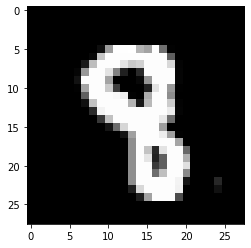

Prediction:  [7]
Label:  7


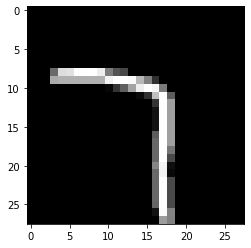

Prediction:  [3]
Label:  3


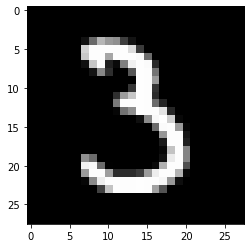

Prediction:  [8]
Label:  8


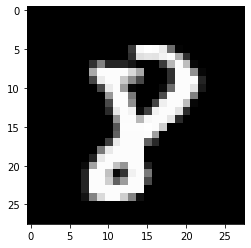

In [25]:
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)

Finally, let's find the accuracy on the dev set:

In [26]:
dev_predictions = make_predictions(X_dev, W1, b1, W2, b2)
get_accuracy(dev_predictions, Y_dev)

[8 9 6 5 4 8 2 6 0 7 9 4 8 0 6 0 5 7 2 1 5 0 8 1 8 3 6 4 2 9 3 2 9 3 4 7 6
 3 0 3 6 4 8 4 7 6 0 7 1 7 1 0 9 8 2 8 0 6 6 8 8 0 2 8 8 1 8 5 0 9 9 6 6 2
 6 9 9 0 3 0 6 0 9 8 9 2 0 8 5 6 6 3 6 8 0 0 0 6 6 4 1 3 5 7 8 8 4 1 6 7 9
 0 2 7 3 8 0 3 1 2 9 2 4 5 8 4 0 5 0 9 4 0 7 0 2 9 7 0 7 0 3 4 1 0 1 9 7 5
 7 9 7 7 7 1 1 4 0 2 4 8 8 7 3 1 6 3 8 1 8 5 6 7 2 2 1 0 1 6 3 5 3 7 3 8 9
 3 6 1 8 1 3 7 0 9 1 6 0 5 8 1 3 5 4 3 1 2 1 1 2 2 1 7 6 9 4 0 0 5 1 6 7 4
 8 3 2 6 8 2 5 4 5 4 2 9 0 9 8 2 1 3 7 0 6 8 9 4 1 5 0 4 9 9 8 0 1 1 5 2 3
 2 6 7 7 9 4 0 7 5 9 3 3 7 5 1 9 4 0 0 8 1 4 4 4 8 2 1 8 3 4 8 9 9 0 1 1 5
 5 3 6 4 1 4 2 3 7 9 9 7 5 6 8 0 2 1 5 1 8 9 6 7 0 1 8 1 7 0 1 0 0 6 3 9 8
 4 8 9 4 4 4 6 8 3 6 5 7 5 3 9 3 3 6 6 1 3 7 3 5 5 6 7 8 7 1 6 0 7 1 4 6 0
 9 9 1 4 1 9 8 2 2 5 4 9 7 8 2 7 9 8 1 4 9 1 3 1 4 2 3 3 0 3 9 9 5 3 4 3 7
 7 3 1 1 8 7 7 9 7 8 6 2 2 1 7 4 1 3 7 2 0 9 5 7 3 0 5 2 9 5 0 7 4 3 9 5 1
 2 3 1 4 7 2 7 9 8 1 1 5 9 1 7 3 4 4 2 0 3 9 1 6 2 1 6 9 1 0 8 3 1 3 9 1 5
 2 9 6 0 1 9 0 9 4 9 6 5 

0.84

Still 84% accuracy, so our model generalized from the training data pretty well.